In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pandas import Series, DataFrame
import pandas as pd
import datetime
import pandas_datareader.data as web
from stockstats import StockDataFrame
#pd.set_option('display.max_rows', -1) # 출력데이터 중간에 안짤리고 다 보여줌


In [2]:
# %matplotlib tk 새창에서 plot 띄우기

함수

In [3]:
def min_max_scaling(x):
    x_out = np.zeros(shape=(x.shape[0],x.shape[1])) #열 별로 따로 min_max_scaling
    x_np = np.asarray(x)
    for x in range(0,x_np.shape[1]):
        x_out[:,x] = (x_np[:,x] - x_np[:,x].min()) / (x_np[:,x].max() - x_np[:,x].min() + 1e-7)
    return x_out

In [4]:
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min() 

Hyperparameter

In [5]:
input_data_column_cnt = 8  #입력데이터의 컴럼 개수
output_data_column_cnt = 1 #결과데이터의 컬럼 개수

seq_length = 20            #1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   #각 셀의 출력 크기
forget_bias = 1.0          #망각 편향(기본값 1.0)
num_stacked_layers = 1     #stacked LSTM layers 개수
keep_prob = 1.0            #dropout할 때 keep할 비율
 
epoch_num = 1000           #에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       #학습률

Load Data

#파일에서 데이터 읽기
stock_file_name = 'LSCC.csv' #주가데이터 파일
encoding = 'euc-kr'          #문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume'] #컬럼 이름
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #csv 파일을 Dataframe 타입으로 Load
raw_dataframe.info() # 데이터 정보 출력

del raw_dataframe['Date'] ## 시간열을 제거하고 dataframe 재생성하지 않기

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다

plt.plot(np.arange(0.,251., 1), stock_info[:,1], label="High")
plt.plot(np.arange(0.,251., 1), stock_info[:,2], label="Low")
plt.plot(np.arange(0.,251., 1), stock_info[:,3], label="Close")
plt.plot(np.arange(0.,251., 1), stock_info[:,4], label="Adj Close")

plt.legend(loc='best')
plt.grid()
plt.show()

In [6]:
stock = web.DataReader("005930.KS", "yahoo", "2010-04-26")
#stock_info = gs.values[:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
stock_info = StockDataFrame.retype(stock)

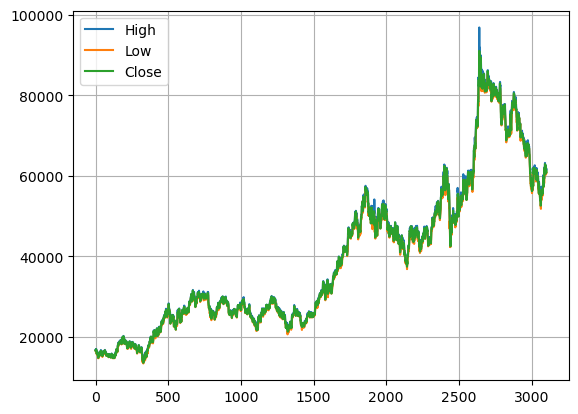

               high      low     open    close      volume     adj close
Date                                                                    
2010-04-26  16840.0  16600.0  16700.0  16680.0  13009350.0  13116.545898
2010-04-27  16760.0  16540.0  16620.0  16700.0  13040500.0  13132.276367
2010-04-28  16500.0  16360.0  16400.0  16500.0  16007500.0  12975.003906
2010-04-29  16620.0  16320.0  16600.0  16500.0  11337150.0  12975.003906
2010-04-30  17040.0  16540.0  16560.0  16980.0  22710850.0  13352.456055
...             ...      ...      ...      ...         ...           ...
2022-11-21  61800.0  60800.0  61400.0  61400.0   9378097.0  61400.000000
2022-11-22  61200.0  60300.0  60900.0  60600.0   9411289.0  60600.000000
2022-11-23  61300.0  60700.0  61200.0  61000.0   8765050.0  61000.000000
2022-11-24  61700.0  60900.0  61200.0  61400.0   8125010.0  61400.000000
2022-11-25  61700.0  60800.0  61400.0  61000.0   6677933.0  61000.000000

[3103 rows x 6 columns]


In [7]:
plt.plot(np.arange(0, stock_info.shape[0],), stock_info['high'], label="High")
plt.plot(np.arange(0, stock_info.shape[0],), stock_info['low'], label="Low")
plt.plot(np.arange(0, stock_info.shape[0],), stock_info['close'], label="Close")

plt.legend(loc='best')
plt.grid()
plt.show()

print(stock_info)

Index

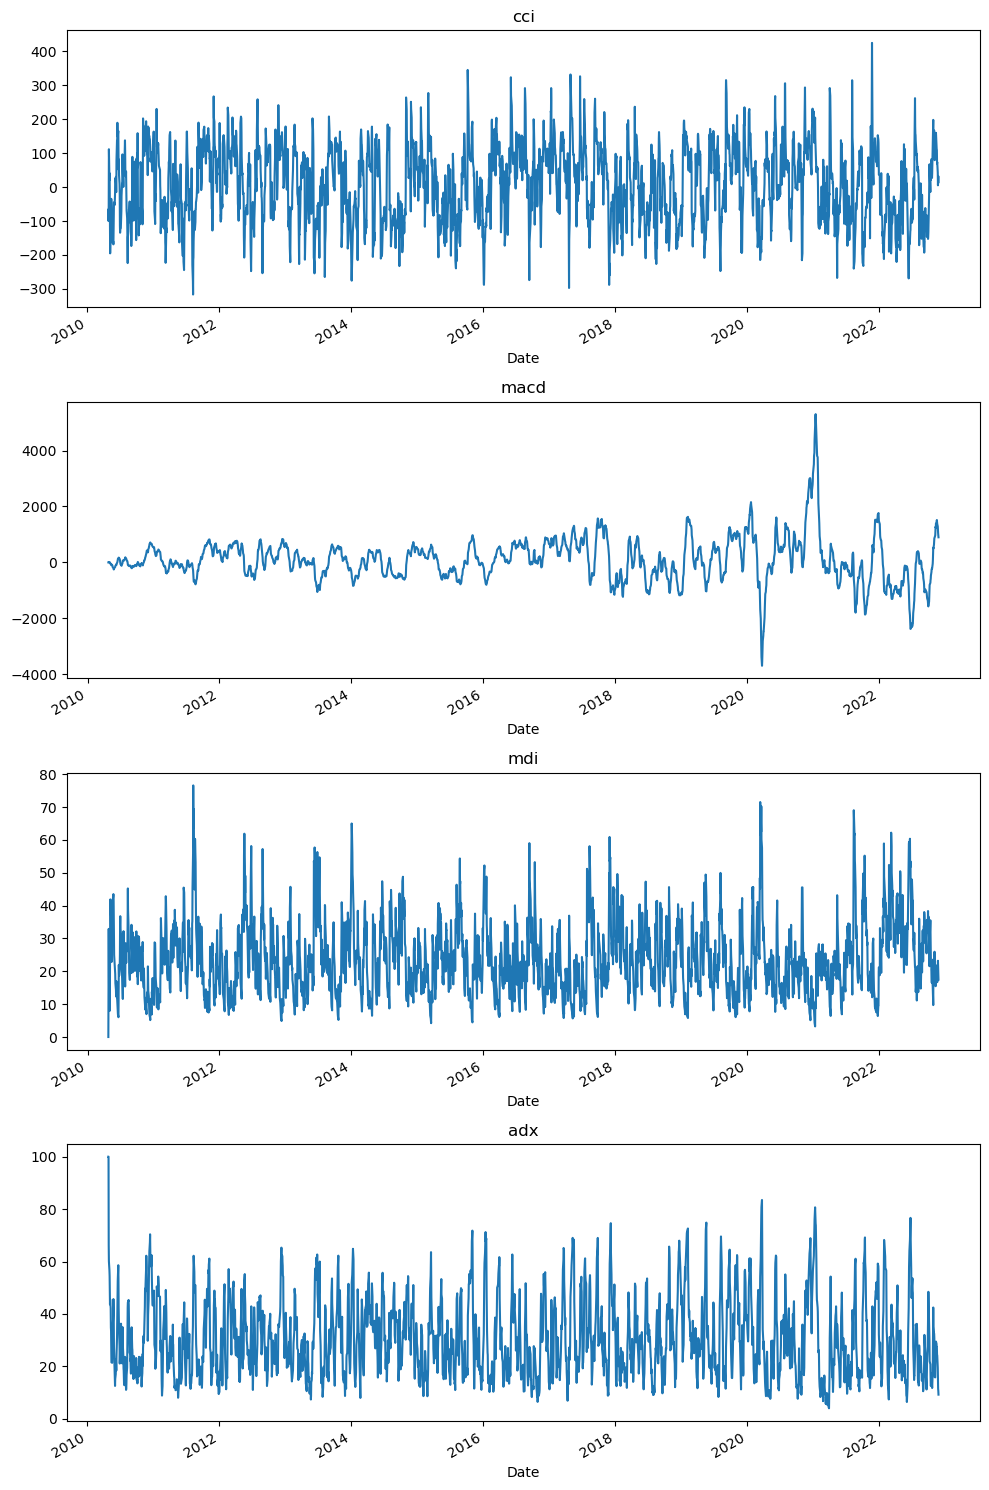

In [8]:

plt.figure(figsize=(10,15)) # 전체 그래프 사이즈
plt.subplot(4,1,1)
stock_info['cci_20'].plot(label="cci")
plt.title('cci')
plt.subplot(4,1,2)
stock_info['macd'].plot(label="macd")
plt.title('macd')
plt.subplot(4,1,3)
stock_info['mdi'].plot(label="mdi")
plt.title('mdi')
plt.subplot(4,1,4)
stock_info['adx'].plot(label="adx")
plt.title('adx')
plt.tight_layout()

Data Preprocessing

In [9]:
# [0,1] 사이로 정규화 
price = stock.values[:,[0,1,3]]
price = np.concatenate([price, stock_info[['cci_20','macd','adx','mdi']]], axis = 1)
# 20일치의 cci 등의 이유로 20번째 데이터까지 자름.
norm_price = min_max_scaling(price[20:]) 

volume = stock.values[:,[4]]
norm_volume = min_max_scaling(volume[20:])

x = np.concatenate((norm_price, norm_volume), axis=1) #고가,저가,종가, cci,macd,adx,mdi,volume
y = x[:, [2]] #타겟 : 종가
print(price)

[[ 1.68400000e+04  1.66000000e+04  1.66800000e+04 ...  0.00000000e+00
              nan  0.00000000e+00]
 [ 1.67600000e+04  1.65400000e+04  1.67000000e+04 ...  4.48717949e-01
   1.00000000e+02  1.39976959e+01]
 [ 1.65000000e+04  1.63600000e+04  1.65000000e+04 ... -5.63023230e+00
   1.00000000e+02  3.29243133e+01]
 ...
 [ 6.13000000e+04  6.07000000e+04  6.10000000e+04 ...  1.04029773e+03
   1.14406172e+01  2.08245854e+01]
 [ 6.17000000e+04  6.09000000e+04  6.14000000e+04 ...  9.84247246e+02
   1.06726537e+01  1.85458714e+01]
 [ 6.17000000e+04  6.08000000e+04  6.10000000e+04 ...  8.97207728e+02
   9.20908081e+00  1.74899095e+01]]


price.shape :  (3103, 7)


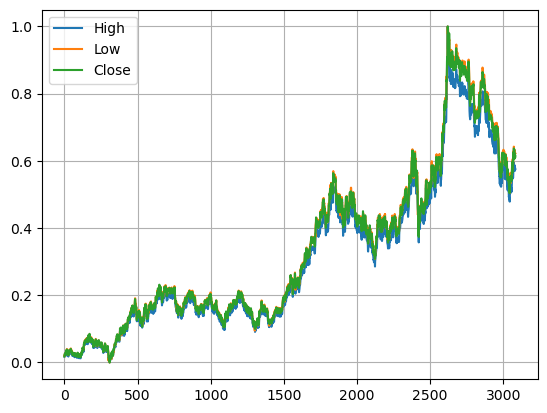

In [10]:
print("price.shape : ", price.shape)
plt.plot(np.arange(0.,stock.shape[0]-20), norm_price[:,0], label="High")
plt.plot(np.arange(0.,stock.shape[0]-20), norm_price[:,1], label="Low")
plt.plot(np.arange(0.,stock.shape[0]-20), norm_price[:,2], label="Close")

plt.legend(loc='best')
plt.grid()
plt.show()


In [11]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가 (정답)
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[0.01737871 0.01919537 0.01808786 0.26015282 0.38263415 0.48281453
  0.43791179 0.25406845]
 [0.01882694 0.01814357 0.02377261 0.30379789 0.38484702 0.41369588
  0.34829038 0.24553691]
 [0.02172339 0.02498028 0.025323   0.36626172 0.3877779  0.29395679
  0.29648055 0.24858709]
 [0.02027516 0.02524323 0.0248062  0.36427385 0.39002096 0.20846465
  0.2600382  0.14145932]
 [0.01979242 0.02445438 0.02273902 0.35586354 0.39077395 0.16482821
  0.25346293 0.12604177]
 [0.02099928 0.02682093 0.0250646  0.3989724  0.39300056 0.10726159
  0.21749301 0.16221925]
 [0.0241371  0.02682093 0.02919897 0.46163213 0.39746566 0.14047598
  0.17910475 0.1395126 ]
 [0.02172339 0.02760978 0.02764858 0.44812244 0.40014943 0.16419796
  0.152162   0.16789051]
 [0.02437847 0.02734683 0.02713178 0.46769865 0.40204738 0.23474786
  0.12414756 0.16056266]
 [0.02293024 0.02471733 0.02325581 0.40967482 0.40120901 0.20325942
  0.18773821 0.19838012]
 [0.02003379 0.02603208 0.02403101 0.40718935 0.40115385 0.18076858
  

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\box15\AppData\Local\Temp\ipykernel_28748\189862625.py:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


In [12]:
# 학승용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

x_train = np.array(dataX[:train_size])
y_train = np.array(dataY[:train_size])
x_test = np.array(dataX[train_size:])
y_test = np.array(dataY[train_size:])

tensorflow 2.0.0 beta0

model

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(seq_length,input_data_column_cnt)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [14]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.LSTM(128, input_shape=(20,3)))
model2.add(tf.keras.layers.Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [15]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.LSTM(128, input_shape=(20,5)))
model3.add(tf.keras.layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68608     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


training

In [16]:

# define the checkpoint
filepath="삼성전자index4개.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, callbacks=callbacks_list )

Epoch 1/500
56/67 [========================>.....] - ETA: 0s - loss: 0.0048
Epoch 1: loss improved from inf to 0.00403, saving model to 삼성전자index4개.hdf5
67/67 [==============================] - 4s 9ms/step - loss: 0.0040 - val_loss: 7.3573e-04
Epoch 2/500
61/67 [==========================>...] - ETA: 0s - loss: 1.3052e-04
Epoch 2: loss improved from 0.00403 to 0.00013, saving model to 삼성전자index4개.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 1.3035e-04 - val_loss: 6.3441e-04
Epoch 3/500
60/67 [=========================>....] - ETA: 0s - loss: 1.1709e-04
Epoch 3: loss improved from 0.00013 to 0.00012, saving model to 삼성전자index4개.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 1.1680e-04 - val_loss: 6.5753e-04
Epoch 4/500
60/67 [=========================>....] - ETA: 0s - loss: 9.9296e-05
Epoch 4: loss improved from 0.00012 to 0.00010, saving model to 삼성전자index4개.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 1.0002e-04 - val_loss:

In [17]:
# define the checkpoint
filepath="삼성전자고저종.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model2.fit(x_train[:,:,:3], y_train, validation_data=(x_test[:,:,:3], y_test), epochs=500, callbacks=callbacks_list )

Epoch 1/500
60/67 [=========================>....] - ETA: 0s - loss: 0.0036
Epoch 1: loss improved from inf to 0.00320, saving model to 삼성전자고저종.hdf5
67/67 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 6.3321e-04
Epoch 2/500
59/67 [=========================>....] - ETA: 0s - loss: 1.6121e-04
Epoch 2: loss improved from 0.00320 to 0.00017, saving model to 삼성전자고저종.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 1.6525e-04 - val_loss: 6.9862e-04
Epoch 3/500
58/67 [========================>.....] - ETA: 0s - loss: 1.5520e-04
Epoch 3: loss improved from 0.00017 to 0.00016, saving model to 삼성전자고저종.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 1.5546e-04 - val_loss: 7.2421e-04
Epoch 4/500
59/67 [=========================>....] - ETA: 0s - loss: 1.5785e-04
Epoch 4: loss did not improve from 0.00016
67/67 [==============================] - 0s 5ms/step - loss: 1.5744e-04 - val_loss: 6.8360e-04
Epoch 5/500
61/67 [===================

In [18]:
# define the checkpoint
filepath="삼성전자index2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model3.fit(x_train[:,:,:5], y_train, validation_data=(x_test[:,:,:5], y_test), epochs=500, callbacks=callbacks_list )

Epoch 1/500
59/67 [=========================>....] - ETA: 0s - loss: 0.0028
Epoch 1: loss improved from inf to 0.00245, saving model to 삼성전자index2.hdf5
67/67 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 6.4192e-04
Epoch 2/500
57/67 [========================>.....] - ETA: 0s - loss: 9.2979e-05
Epoch 2: loss improved from 0.00245 to 0.00009, saving model to 삼성전자index2.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 9.4121e-05 - val_loss: 5.9221e-04
Epoch 3/500
61/67 [==========================>...] - ETA: 0s - loss: 8.7358e-05
Epoch 3: loss improved from 0.00009 to 0.00009, saving model to 삼성전자index2.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 8.6685e-05 - val_loss: 6.1270e-04
Epoch 4/500
63/67 [===========================>..] - ETA: 0s - loss: 8.6493e-05
Epoch 4: loss improved from 0.00009 to 0.00009, saving model to 삼성전자index2.hdf5
67/67 [==============================] - 0s 5ms/step - loss: 8.5324e-05 - val_loss: 5.9

predict

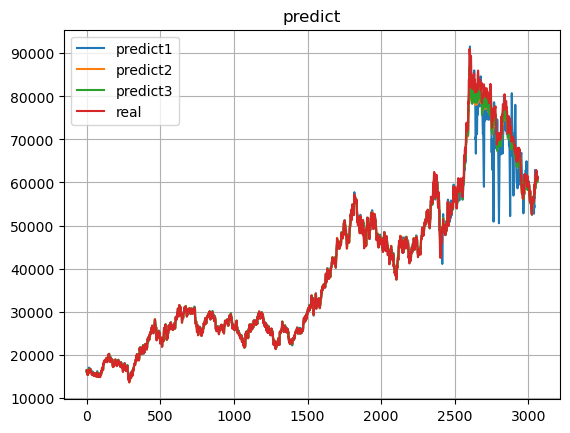

In [19]:
test_predict1 = model.predict(np.array(dataX), verbose=0)
test_predict1 = reverse_min_max_scaling(price[:,2], test_predict1)

test_predict2 = model2.predict(np.array(dataX)[:,:,:3], verbose=0)
test_predict2 = reverse_min_max_scaling(price[:,2], test_predict2)

test_predict3 = model3.predict(np.array(dataX)[:,:,:5], verbose=0)
test_predict3 = reverse_min_max_scaling(price[:,2], test_predict3)

#plt.figure(figsize=(20,20))
plt.plot(np.arange(0,test_predict1.shape[0]), test_predict1, label="predict1")
plt.plot(np.arange(0,test_predict1.shape[0]), test_predict2, label="predict2")
plt.plot(np.arange(0,test_predict1.shape[0]), test_predict3, label="predict3")
plt.plot(np.arange(0,test_predict1.shape[0]), price[seq_length+20:,2], label="real")
plt.title('predict')
plt.legend(loc='best')
plt.grid()
plt.show()